# Method 3 - Best Ideas High Liquidity

In [1]:
%matplotlib inline
import pandas as pd
import warnings
from statsmodels import api as sm

from eptooling import crsp, epd, fs, hfu, crsp, db, bi
from eptooling.bm import bmdb, iso
from epquant.engine import weights, portfolio
from epquant.gen import returns
from epquant.perf import relative_performance

warnings.filterwarnings("ignore")

## Fetch Holdings and Benchmark Data

In [2]:
# Get HFU Data

%store -r inst_data
inst_data = inst_data[inst_data['datadate'] >= '1999-06-30']

# Count number of positions per manager

inst_data['num_pos'] = inst_data.groupby(['datadate', 'institution_id'])[
    'fsym_id'].transform(lambda s: s.nunique())

# Remove less than 20 holdings and less than $5mm per CSP

valid_data = inst_data[inst_data['num_pos'] >= 20]
valid_data = valid_data[valid_data['public_aum'] >= 5e6]

# Calculate Intra-Portfolio Cap Weight

valid_data['weight'] = valid_data['market_cap_val_cur'] / valid_data.groupby(
    ['datadate', 'institution_id'])['market_cap_val_cur'].transform('sum')

# Calculate Intra-Portfolio Cap Weight Tilt

valid_data['adj_target'] = valid_data['target'] - valid_data['weight'].fillna(0)

## Calculate Best Ideas

In [3]:
# Extract Best Ideas

valid_data['pos_rank'] = valid_data\
    .groupby(['datadate', 'institution_id'])['adj_target'].rank(ascending=False)

best_ideas = valid_data[valid_data['pos_rank'] == 1].copy()

# Get Liquidity

distinct_ideas = best_ideas[['datadate', 'fsym_id']].drop_duplicates()
distinct_ideas['in'] = 1

bid_asks = crsp.get_crsp_fsym_bid_ask(list(set(distinct_ideas['fsym_id'].dropna())),
                                      distinct_ideas['datadate'].min(), pd.datetime(2018, 12, 31))
bid_asks['rel_bid_ask'] = (bid_asks['ask'] - bid_asks['bid']) / ((bid_asks['bid'] + bid_asks['ask']) / 2)
bid_asks['datadate'] = bid_asks['datadate'] + pd.offsets.QuarterEnd(0)
qe_bid_asks = bid_asks.groupby(['datadate', 'fsym_id'])['rel_bid_ask'].mean().reset_index()
qe_bid_asks = qe_bid_asks.merge(distinct_ideas)

qe_bid_asks['median_bid_ask'] = qe_bid_asks.groupby('datadate')['rel_bid_ask'].transform('median')
qe_bid_asks = qe_bid_asks[qe_bid_asks['rel_bid_ask'] < qe_bid_asks['median_bid_ask']]

best_ideas = best_ideas.merge(qe_bid_asks)

# Weight the best ideas equally

best_ideas['target'] = 1 / best_ideas.groupby('datadate')['institution_id'].transform('count')

## Backtest Portfolio

In [4]:
w = weights.Weights(best_ideas)

%store -r r

p = portfolio.DailyPortfolio(w, r, end_date='2018-12-31')

rf = bi.get_risk_free_rate()
monthly_return = p.port_return.loc['1999-07-01':].resample('M').apply(epd.prod_red)
monthly_return = (monthly_return - rf).dropna()
monthly_return.name = 'port_return'

## Plot Performance

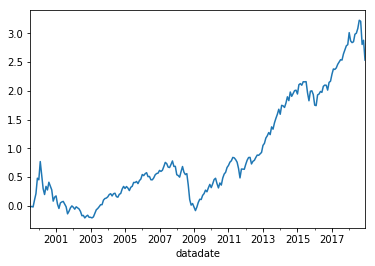

In [5]:
epd.nav(monthly_return).plot()

In [6]:
monthly_return.resample('A').apply(epd.prod_red)

datadate
1999-12-31    0.480118
2000-12-31   -0.222518
2001-12-31   -0.132018
2002-12-31   -0.198718
2003-12-31    0.418329
2004-12-31    0.178536
2005-12-31    0.095210
2006-12-31    0.070302
2007-12-31    0.075361
2008-12-31   -0.383085
2009-12-31    0.319456
2010-12-31    0.214304
2011-12-31   -0.018834
2012-12-31    0.179008
2013-12-31    0.389133
2014-12-31    0.123481
2015-12-31   -0.024936
2016-12-31    0.078890
2017-12-31    0.200630
2018-12-31   -0.070617
Freq: A-DEC, Name: port_return, dtype: float64

## Fetch Factor Models

In [7]:
# Get Factor Models
q_factor_model = bi.get_q_factor_model()
fama_french_five_factor_model = bi.get_fama_french_five_factor_model()
four_factor_model = bi.get_four_factor_model()

# Concat Portfolio Return
q_factor = pd.concat([monthly_return, q_factor_model], axis=1)
fama_french_five = pd.concat([monthly_return, fama_french_five_factor_model], axis=1)
four_factor = pd.concat([monthly_return, four_factor_model], axis=1)

# Add Constants
q_factor.insert(1, 'const', 1)
fama_french_five.insert(1, 'const', 1)
four_factor.insert(1, 'const', 1)

# Split Period into Pre and Post Crisis
q_factor_pre, q_factor_post = q_factor.loc[:'2009-06-30'], q_factor.loc['2009-07-31':]
fama_french_five_pre, fama_french_five_post = fama_french_five.loc[:'2009-06-30'], fama_french_five.loc['2009-07-31':] 
four_factor_pre, four_factor_post = four_factor.loc[:'2009-06-30'], four_factor.loc['2009-07-31':] 

## Full Time Period Regressions

### Q Factor Model

In [8]:
sm.OLS(q_factor.iloc[:, :1], q_factor.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.872
Model:                            OLS   Adj. R-squared:                  0.869
Method:                 Least Squares   F-statistic:                     388.7
Date:                Mon, 27 Apr 2020   Prob (F-statistic):          8.47e-101
Time:                        13:50:56   Log-Likelihood:                 600.28
No. Observations:                 234   AIC:                            -1191.
Df Residuals:                     229   BIC:                            -1173.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0023      0.001      1.766      0.079      -0.000       0.005
mktrf          0.8830      0.035     25.171      0.000       0.814       0.952
me             0.4804      0.041     11.772      0.000       0.400       0.561
ia            -0.4601      0.062     -7.419      0.000      -0.582      -0.338
roe            0.0046      0.053      0.086      0.931      -0.100       0.109
==============================================================================
Omnibus:                       70.935   Durbin-Watson:                   1.980
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1200.340
Skew:                           0.644   Prob(JB):                    2.24e-261
Kurtosis:                      14.021   Cond. No.                         53.0
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Q Factor Model - Newey West (9 Lag)

In [9]:
sm.OLS(q_factor.iloc[:, :1], q_factor.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.872
Model:                            OLS   Adj. R-squared:                  0.869
Method:                 Least Squares   F-statistic:                     174.2
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           3.06e-68
Time:                        13:50:56   Log-Likelihood:                 600.28
No. Observations:                 234   AIC:                            -1191.
Df Residuals:                     229   BIC:                            -1173.
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0023      0.001      1.830      0.067      -0.000       0.005
mktrf          0.8830      0.055     16.071      0.000       0.775       0.991
me             0.4804      0.118      4.083      0.000       0.250       0.711
ia            -0.4601      0.124     -3.711      0.000      -0.703      -0.217
roe            0.0046      0.086      0.053      0.958      -0.165       0.174
==============================================================================
Omnibus:                       70.935   Durbin-Watson:                   1.980
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1200.340
Skew:                           0.644   Prob(JB):                    2.24e-261
Kurtosis:                      14.021   Cond. No.                         53.0
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Q Factor Model - Newey West (18 Lag)

In [10]:
sm.OLS(q_factor.iloc[:, :1], q_factor.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.872
Model:                            OLS   Adj. R-squared:                  0.869
Method:                 Least Squares   F-statistic:                     238.6
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           1.99e-80
Time:                        13:50:56   Log-Likelihood:                 600.28
No. Observations:                 234   AIC:                            -1191.
Df Residuals:                     229   BIC:                            -1173.
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0023      0.001      1.873      0.061      -0.000       0.005
mktrf          0.8830      0.038     23.249      0.000       0.809       0.957
me             0.4804      0.120      4.005      0.000       0.245       0.715
ia            -0.4601      0.115     -3.988      0.000      -0.686      -0.234
roe            0.0046      0.073      0.063      0.950      -0.138       0.147
==============================================================================
Omnibus:                       70.935   Durbin-Watson:                   1.980
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1200.340
Skew:                           0.644   Prob(JB):                    2.24e-261
Kurtosis:                      14.021   Cond. No.                         53.0
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Fama French Five Factor Model

In [11]:
sm.OLS(fama_french_five.iloc[:, :1], fama_french_five.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.884
Model:                            OLS   Adj. R-squared:                  0.881
Method:                 Least Squares   F-statistic:                     346.6
Date:                Mon, 27 Apr 2020   Prob (F-statistic):          2.25e-104
Time:                        13:50:56   Log-Likelihood:                 611.88
No. Observations:                 234   AIC:                            -1212.
Df Residuals:                     228   BIC:                            -1191.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0032      0.001      2.571      0.011       0.001       0.006
mktrf          0.8643      0.034     25.783      0.000       0.798       0.930
smb            0.4210      0.044      9.519      0.000       0.334       0.508
hml           -0.2753      0.052     -5.279      0.000      -0.378      -0.173
rmw           -0.1914      0.059     -3.246      0.001      -0.308      -0.075
cma           -0.0276      0.075     -0.368      0.713      -0.175       0.120
==============================================================================
Omnibus:                       62.651   Durbin-Watson:                   2.051
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              579.105
Skew:                           0.718   Prob(JB):                    1.77e-126
Kurtosis:                      10.572   Cond. No.                         72.5
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Fama French Five Factor Model - Newey West (9 Lag)

In [12]:
sm.OLS(fama_french_five.iloc[:, :1], fama_french_five.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.884
Model:                            OLS   Adj. R-squared:                  0.881
Method:                 Least Squares   F-statistic:                     552.2
Date:                Mon, 27 Apr 2020   Prob (F-statistic):          3.26e-125
Time:                        13:50:56   Log-Likelihood:                 611.88
No. Observations:                 234   AIC:                            -1212.
Df Residuals:                     228   BIC:                            -1191.
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0032      0.001      2.374      0.018       0.001       0.006
mktrf          0.8643      0.050     17.417      0.000       0.767       0.962
smb            0.4210      0.083      5.076      0.000       0.258       0.584
hml           -0.2753      0.080     -3.427      0.001      -0.433      -0.118
rmw           -0.1914      0.122     -1.570      0.116      -0.430       0.048
cma           -0.0276      0.170     -0.162      0.871      -0.361       0.306
==============================================================================
Omnibus:                       62.651   Durbin-Watson:                   2.051
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              579.105
Skew:                           0.718   Prob(JB):                    1.77e-126
Kurtosis:                      10.572   Cond. No.                         72.5
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Fama French Five Factor Model - Newey West (18 Lag)

In [13]:
sm.OLS(fama_french_five.iloc[:, :1], fama_french_five.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.884
Model:                            OLS   Adj. R-squared:                  0.881
Method:                 Least Squares   F-statistic:                     651.9
Date:                Mon, 27 Apr 2020   Prob (F-statistic):          7.66e-133
Time:                        13:50:56   Log-Likelihood:                 611.88
No. Observations:                 234   AIC:                            -1212.
Df Residuals:                     228   BIC:                            -1191.
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0032      0.001      2.312      0.021       0.000       0.006
mktrf          0.8643      0.045     19.036      0.000       0.775       0.953
smb            0.4210      0.076      5.556      0.000       0.273       0.570
hml           -0.2753      0.084     -3.265      0.001      -0.441      -0.110
rmw           -0.1914      0.127     -1.513      0.130      -0.439       0.057
cma           -0.0276      0.188     -0.147      0.883      -0.396       0.341
==============================================================================
Omnibus:                       62.651   Durbin-Watson:                   2.051
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              579.105
Skew:                           0.718   Prob(JB):                    1.77e-126
Kurtosis:                      10.572   Cond. No.                         72.5
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Carhart Four Factor Model

In [14]:
sm.OLS(four_factor.iloc[:, :1], four_factor.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.904
Model:                            OLS   Adj. R-squared:                  0.903
Method:                 Least Squares   F-statistic:                     541.7
Date:                Mon, 27 Apr 2020   Prob (F-statistic):          1.88e-115
Time:                        13:50:56   Log-Likelihood:                 634.79
No. Observations:                 234   AIC:                            -1260.
Df Residuals:                     229   BIC:                            -1242.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0010      0.001      0.966      0.335      -0.001       0.003
mktrf          1.0053      0.028     36.073      0.000       0.950       1.060
smb            0.4144      0.035     11.912      0.000       0.346       0.483
hml           -0.2164      0.035     -6.263      0.000      -0.285      -0.148
umd            0.1700      0.023      7.500      0.000       0.125       0.215
==============================================================================
Omnibus:                       45.846   Durbin-Watson:                   1.979
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              495.644
Skew:                           0.256   Prob(JB):                    2.36e-108
Kurtosis:                      10.111   Cond. No.                         36.8
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Carhart Four Factor Model - Newey West (9 Lag)

In [15]:
sm.OLS(four_factor.iloc[:, :1], four_factor.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.904
Model:                            OLS   Adj. R-squared:                  0.903
Method:                 Least Squares   F-statistic:                     204.7
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           2.16e-74
Time:                        13:50:56   Log-Likelihood:                 634.79
No. Observations:                 234   AIC:                            -1260.
Df Residuals:                     229   BIC:                            -1242.
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0010      0.001      1.223      0.221      -0.001       0.003
mktrf          1.0053      0.043     23.193      0.000       0.920       1.090
smb            0.4144      0.079      5.242      0.000       0.259       0.569
hml           -0.2164      0.050     -4.308      0.000      -0.315      -0.118
umd            0.1700      0.045      3.740      0.000       0.081       0.259
==============================================================================
Omnibus:                       45.846   Durbin-Watson:                   1.979
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              495.644
Skew:                           0.256   Prob(JB):                    2.36e-108
Kurtosis:                      10.111   Cond. No.                         36.8
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Carhart Four Factor Model - Newey West (18 Lag)

In [16]:
sm.OLS(four_factor.iloc[:, :1], four_factor.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.904
Model:                            OLS   Adj. R-squared:                  0.903
Method:                 Least Squares   F-statistic:                     182.5
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           5.44e-70
Time:                        13:50:56   Log-Likelihood:                 634.79
No. Observations:                 234   AIC:                            -1260.
Df Residuals:                     229   BIC:                            -1242.
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0010      0.001      1.290      0.197      -0.001       0.003
mktrf          1.0053      0.043     23.641      0.000       0.922       1.089
smb            0.4144      0.065      6.378      0.000       0.287       0.542
hml           -0.2164      0.046     -4.672      0.000      -0.307      -0.126
umd            0.1700      0.050      3.388      0.001       0.072       0.268
==============================================================================
Omnibus:                       45.846   Durbin-Watson:                   1.979
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              495.644
Skew:                           0.256   Prob(JB):                    2.36e-108
Kurtosis:                      10.111   Cond. No.                         36.8
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

## Pre-Crisis Regressions

### Q Factor Model

In [17]:
sm.OLS(q_factor_pre.iloc[:, :1], q_factor_pre.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.861
Model:                            OLS   Adj. R-squared:                  0.857
Method:                 Least Squares   F-statistic:                     178.6
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           2.33e-48
Time:                        13:50:56   Log-Likelihood:                 280.63
No. Observations:                 120   AIC:                            -551.3
Df Residuals:                     115   BIC:                            -537.3
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0020      0.002      0.869      0.387      -0.003       0.006
mktrf          0.8986      0.061     14.621      0.000       0.777       1.020
me             0.5865      0.061      9.663      0.000       0.466       0.707
ia            -0.5520      0.095     -5.808      0.000      -0.740      -0.364
roe            0.0589      0.084      0.700      0.485      -0.108       0.226
==============================================================================
Omnibus:                       33.496   Durbin-Watson:                   1.976
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              205.736
Skew:                           0.677   Prob(JB):                     2.11e-45
Kurtosis:                       9.270   Cond. No.                         47.0
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Q Factor Model - Newey West (9 Lag)

In [18]:
sm.OLS(q_factor_pre.iloc[:, :1], q_factor_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.861
Model:                            OLS   Adj. R-squared:                  0.857
Method:                 Least Squares   F-statistic:                     73.23
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           1.02e-30
Time:                        13:50:56   Log-Likelihood:                 280.63
No. Observations:                 120   AIC:                            -551.3
Df Residuals:                     115   BIC:                            -537.3
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0020      0.002      0.904      0.366      -0.002       0.006
mktrf          0.8986      0.092      9.809      0.000       0.719       1.078
me             0.5865      0.113      5.198      0.000       0.365       0.808
ia            -0.5520      0.141     -3.907      0.000      -0.829      -0.275
roe            0.0589      0.110      0.538      0.591      -0.156       0.274
==============================================================================
Omnibus:                       33.496   Durbin-Watson:                   1.976
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              205.736
Skew:                           0.677   Prob(JB):                     2.11e-45
Kurtosis:                       9.270   Cond. No.                         47.0
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Q Factor Model - Newey West (18 Lag)

In [19]:
sm.OLS(q_factor_pre.iloc[:, :1], q_factor_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.861
Model:                            OLS   Adj. R-squared:                  0.857
Method:                 Least Squares   F-statistic:                     90.53
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           1.31e-34
Time:                        13:50:56   Log-Likelihood:                 280.63
No. Observations:                 120   AIC:                            -551.3
Df Residuals:                     115   BIC:                            -537.3
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0020      0.002      0.969      0.333      -0.002       0.006
mktrf          0.8986      0.070     12.918      0.000       0.762       1.035
me             0.5865      0.115      5.079      0.000       0.360       0.813
ia            -0.5520      0.129     -4.278      0.000      -0.805      -0.299
roe            0.0589      0.079      0.745      0.457      -0.096       0.214
==============================================================================
Omnibus:                       33.496   Durbin-Watson:                   1.976
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              205.736
Skew:                           0.677   Prob(JB):                     2.11e-45
Kurtosis:                       9.270   Cond. No.                         47.0
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Fama French Five Factor Model

In [20]:
sm.OLS(fama_french_five_pre.iloc[:, :1], fama_french_five_pre.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.875
Model:                            OLS   Adj. R-squared:                  0.870
Method:                 Least Squares   F-statistic:                     159.9
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           8.41e-50
Time:                        13:50:56   Log-Likelihood:                 286.95
No. Observations:                 120   AIC:                            -561.9
Df Residuals:                     114   BIC:                            -545.2
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0044      0.002      1.973      0.051   -1.78e-05       0.009
mktrf          0.8674      0.062     14.046      0.000       0.745       0.990
smb            0.5204      0.070      7.441      0.000       0.382       0.659
hml           -0.3157      0.086     -3.684      0.000      -0.485      -0.146
rmw           -0.1461      0.101     -1.446      0.151      -0.346       0.054
cma           -0.0498      0.111     -0.450      0.654      -0.269       0.170
==============================================================================
Omnibus:                       25.044   Durbin-Watson:                   2.127
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              101.415
Skew:                           0.560   Prob(JB):                     9.51e-23
Kurtosis:                       7.362   Cond. No.                         67.9
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Fama French Five Factor Model - Newey West (9 Lag)

In [21]:
sm.OLS(fama_french_five_pre.iloc[:, :1], fama_french_five_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.875
Model:                            OLS   Adj. R-squared:                  0.870
Method:                 Least Squares   F-statistic:                     212.7
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           4.51e-56
Time:                        13:50:56   Log-Likelihood:                 286.95
No. Observations:                 120   AIC:                            -561.9
Df Residuals:                     114   BIC:                            -545.2
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0044      0.002      1.855      0.064      -0.000       0.009
mktrf          0.8674      0.083     10.426      0.000       0.704       1.030
smb            0.5204      0.091      5.700      0.000       0.341       0.699
hml           -0.3157      0.085     -3.701      0.000      -0.483      -0.149
rmw           -0.1461      0.129     -1.134      0.257      -0.399       0.106
cma           -0.0498      0.231     -0.215      0.829      -0.503       0.403
==============================================================================
Omnibus:                       25.044   Durbin-Watson:                   2.127
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              101.415
Skew:                           0.560   Prob(JB):                     9.51e-23
Kurtosis:                       7.362   Cond. No.                         67.9
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Fama French Five Factor Model - Newey West (18 Lag)

In [22]:
sm.OLS(fama_french_five_pre.iloc[:, :1], fama_french_five_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.875
Model:                            OLS   Adj. R-squared:                  0.870
Method:                 Least Squares   F-statistic:                     260.3
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           1.30e-60
Time:                        13:50:56   Log-Likelihood:                 286.95
No. Observations:                 120   AIC:                            -561.9
Df Residuals:                     114   BIC:                            -545.2
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0044      0.002      1.780      0.075      -0.000       0.009
mktrf          0.8674      0.079     10.915      0.000       0.712       1.023
smb            0.5204      0.073      7.093      0.000       0.377       0.664
hml           -0.3157      0.088     -3.595      0.000      -0.488      -0.144
rmw           -0.1461      0.133     -1.102      0.270      -0.406       0.114
cma           -0.0498      0.253     -0.197      0.844      -0.546       0.446
==============================================================================
Omnibus:                       25.044   Durbin-Watson:                   2.127
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              101.415
Skew:                           0.560   Prob(JB):                     9.51e-23
Kurtosis:                       7.362   Cond. No.                         67.9
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Carhart Four Factor Model

In [23]:
sm.OLS(four_factor_pre.iloc[:, :1], four_factor_pre.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.911
Model:                            OLS   Adj. R-squared:                  0.908
Method:                 Least Squares   F-statistic:                     296.0
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           1.54e-59
Time:                        13:50:56   Log-Likelihood:                 307.55
No. Observations:                 120   AIC:                            -605.1
Df Residuals:                     115   BIC:                            -591.2
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0028      0.002      1.580      0.117      -0.001       0.006
mktrf          1.0794      0.043     24.949      0.000       0.994       1.165
smb            0.4455      0.049      9.045      0.000       0.348       0.543
hml           -0.2394      0.049     -4.853      0.000      -0.337      -0.142
umd            0.2161      0.030      7.105      0.000       0.156       0.276
==============================================================================
Omnibus:                       21.476   Durbin-Watson:                   2.104
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              104.855
Skew:                          -0.309   Prob(JB):                     1.70e-23
Kurtosis:                       7.538   Cond. No.                         33.2
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Carhart Four Factor Model - Newey West (9 Lag)

In [24]:
sm.OLS(four_factor_pre.iloc[:, :1], four_factor_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.911
Model:                            OLS   Adj. R-squared:                  0.908
Method:                 Least Squares   F-statistic:                     161.8
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           2.91e-46
Time:                        13:50:56   Log-Likelihood:                 307.55
No. Observations:                 120   AIC:                            -605.1
Df Residuals:                     115   BIC:                            -591.2
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0028      0.001      2.040      0.041       0.000       0.006
mktrf          1.0794      0.062     17.548      0.000       0.959       1.200
smb            0.4455      0.076      5.851      0.000       0.296       0.595
hml           -0.2394      0.053     -4.482      0.000      -0.344      -0.135
umd            0.2161      0.047      4.588      0.000       0.124       0.308
==============================================================================
Omnibus:                       21.476   Durbin-Watson:                   2.104
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              104.855
Skew:                          -0.309   Prob(JB):                     1.70e-23
Kurtosis:                       7.538   Cond. No.                         33.2
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Carhart Four Factor Model - Newey West (18 Lag)

In [25]:
sm.OLS(four_factor_pre.iloc[:, :1], four_factor_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.911
Model:                            OLS   Adj. R-squared:                  0.908
Method:                 Least Squares   F-statistic:                     139.6
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           3.60e-43
Time:                        13:50:56   Log-Likelihood:                 307.55
No. Observations:                 120   AIC:                            -605.1
Df Residuals:                     115   BIC:                            -591.2
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0028      0.001      2.454      0.014       0.001       0.005
mktrf          1.0794      0.052     20.627      0.000       0.977       1.182
smb            0.4455      0.055      8.035      0.000       0.337       0.554
hml           -0.2394      0.044     -5.454      0.000      -0.325      -0.153
umd            0.2161      0.047      4.645      0.000       0.125       0.307
==============================================================================
Omnibus:                       21.476   Durbin-Watson:                   2.104
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              104.855
Skew:                          -0.309   Prob(JB):                     1.70e-23
Kurtosis:                       7.538   Cond. No.                         33.2
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

## Post-Crisis Regressions

### Q Factor Model

In [26]:
sm.OLS(q_factor_post.iloc[:, :1], q_factor_post.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.962
Model:                            OLS   Adj. R-squared:                  0.960
Method:                 Least Squares   F-statistic:                     682.7
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           3.65e-76
Time:                        13:50:56   Log-Likelihood:                 400.03
No. Observations:                 114   AIC:                            -790.1
Df Residuals:                     109   BIC:                            -776.4
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0014      0.001      1.893      0.061   -6.56e-05       0.003
mktrf          0.9360      0.022     42.990      0.000       0.893       0.979
me             0.1592      0.034      4.736      0.000       0.093       0.226
ia            -0.1678      0.047     -3.598      0.000      -0.260      -0.075
roe            0.0020      0.041      0.049      0.961      -0.079       0.083
==============================================================================
Omnibus:                        6.144   Durbin-Watson:                   2.074
Prob(Omnibus):                  0.046   Jarque-Bera (JB):                3.530
Skew:                           0.226   Prob(JB):                        0.171
Kurtosis:                       2.266   Cond. No.                         67.7
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Q Factor Model - Newey West (9 Lag)

In [27]:
sm.OLS(q_factor_post.iloc[:, :1], q_factor_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.962
Model:                            OLS   Adj. R-squared:                  0.960
Method:                 Least Squares   F-statistic:                     875.9
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           7.43e-82
Time:                        13:50:57   Log-Likelihood:                 400.03
No. Observations:                 114   AIC:                            -790.1
Df Residuals:                     109   BIC:                            -776.4
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0014      0.001      1.755      0.079      -0.000       0.003
mktrf          0.9360      0.019     48.165      0.000       0.898       0.974
me             0.1592      0.040      4.015      0.000       0.081       0.237
ia            -0.1678      0.048     -3.488      0.000      -0.262      -0.073
roe            0.0020      0.038      0.053      0.957      -0.072       0.076
==============================================================================
Omnibus:                        6.144   Durbin-Watson:                   2.074
Prob(Omnibus):                  0.046   Jarque-Bera (JB):                3.530
Skew:                           0.226   Prob(JB):                        0.171
Kurtosis:                       2.266   Cond. No.                         67.7
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Q Factor Model - Newey West (18 Lag)

In [28]:
sm.OLS(q_factor_post.iloc[:, :1], q_factor_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.962
Model:                            OLS   Adj. R-squared:                  0.960
Method:                 Least Squares   F-statistic:                     1135.
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           7.93e-88
Time:                        13:50:57   Log-Likelihood:                 400.03
No. Observations:                 114   AIC:                            -790.1
Df Residuals:                     109   BIC:                            -776.4
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0014      0.001      1.593      0.111      -0.000       0.003
mktrf          0.9360      0.019     50.332      0.000       0.900       0.972
me             0.1592      0.039      4.100      0.000       0.083       0.235
ia            -0.1678      0.051     -3.278      0.001      -0.268      -0.067
roe            0.0020      0.035      0.057      0.954      -0.067       0.071
==============================================================================
Omnibus:                        6.144   Durbin-Watson:                   2.074
Prob(Omnibus):                  0.046   Jarque-Bera (JB):                3.530
Skew:                           0.226   Prob(JB):                        0.171
Kurtosis:                       2.266   Cond. No.                         67.7
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Fama French Five Factor Model

In [29]:
sm.OLS(fama_french_five_post.iloc[:, :1], fama_french_five_post.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.959
Model:                            OLS   Adj. R-squared:                  0.957
Method:                 Least Squares   F-statistic:                     499.5
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           6.48e-73
Time:                        13:50:57   Log-Likelihood:                 395.64
No. Observations:                 114   AIC:                            -779.3
Df Residuals:                     108   BIC:                            -762.9
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0005      0.001      0.707      0.481      -0.001       0.002
mktrf          0.9336      0.022     43.067      0.000       0.891       0.977
smb            0.1617      0.035      4.595      0.000       0.092       0.231
hml           -0.0834      0.045     -1.858      0.066      -0.172       0.006
rmw           -0.0302      0.055     -0.549      0.584      -0.139       0.079
cma           -0.0753      0.070     -1.079      0.283      -0.214       0.063
==============================================================================
Omnibus:                        2.105   Durbin-Watson:                   2.039
Prob(Omnibus):                  0.349   Jarque-Bera (JB):                1.559
Skew:                           0.238   Prob(JB):                        0.459
Kurtosis:                       3.319   Cond. No.                         109.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Fama French Five Factor Model - Newey West (9 Lag)

In [30]:
sm.OLS(fama_french_five_post.iloc[:, :1], fama_french_five_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.959
Model:                            OLS   Adj. R-squared:                  0.957
Method:                 Least Squares   F-statistic:                     499.5
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           6.48e-73
Time:                        13:50:57   Log-Likelihood:                 395.64
No. Observations:                 114   AIC:                            -779.3
Df Residuals:                     108   BIC:                            -762.9
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0005      0.001      0.632      0.527      -0.001       0.002
mktrf          0.9336      0.022     42.923      0.000       0.891       0.976
smb            0.1617      0.040      4.065      0.000       0.084       0.240
hml           -0.0834      0.031     -2.664      0.008      -0.145      -0.022
rmw           -0.0302      0.044     -0.678      0.498      -0.117       0.057
cma           -0.0753      0.060     -1.265      0.206      -0.192       0.041
==============================================================================
Omnibus:                        2.105   Durbin-Watson:                   2.039
Prob(Omnibus):                  0.349   Jarque-Bera (JB):                1.559
Skew:                           0.238   Prob(JB):                        0.459
Kurtosis:                       3.319   Cond. No.                         109.
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Fama French Five Factor Model - Newey West (18 Lag)

In [31]:
sm.OLS(fama_french_five_post.iloc[:, :1], fama_french_five_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.959
Model:                            OLS   Adj. R-squared:                  0.957
Method:                 Least Squares   F-statistic:                     1066.
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           3.75e-90
Time:                        13:50:57   Log-Likelihood:                 395.64
No. Observations:                 114   AIC:                            -779.3
Df Residuals:                     108   BIC:                            -762.9
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0005      0.001      0.622      0.534      -0.001       0.002
mktrf          0.9336      0.017     55.008      0.000       0.900       0.967
smb            0.1617      0.036      4.431      0.000       0.090       0.233
hml           -0.0834      0.027     -3.142      0.002      -0.135      -0.031
rmw           -0.0302      0.047     -0.643      0.520      -0.122       0.062
cma           -0.0753      0.058     -1.308      0.191      -0.188       0.038
==============================================================================
Omnibus:                        2.105   Durbin-Watson:                   2.039
Prob(Omnibus):                  0.349   Jarque-Bera (JB):                1.559
Skew:                           0.238   Prob(JB):                        0.459
Kurtosis:                       3.319   Cond. No.                         109.
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Carhart Four Factor Model

In [32]:
sm.OLS(four_factor_post.iloc[:, :1], four_factor_post.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.958
Model:                            OLS   Adj. R-squared:                  0.957
Method:                 Least Squares   F-statistic:                     625.7
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           3.50e-74
Time:                        13:50:57   Log-Likelihood:                 395.25
No. Observations:                 114   AIC:                            -780.5
Df Residuals:                     109   BIC:                            -766.8
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0002      0.001      0.286      0.776      -0.001       0.002
mktrf          0.9442      0.022     43.884      0.000       0.902       0.987
smb            0.1641      0.034      4.892      0.000       0.098       0.231
hml           -0.0778      0.035     -2.253      0.026      -0.146      -0.009
umd            0.0342      0.026      1.312      0.192      -0.017       0.086
==============================================================================
Omnibus:                        2.055   Durbin-Watson:                   1.985
Prob(Omnibus):                  0.358   Jarque-Bera (JB):                1.537
Skew:                           0.170   Prob(JB):                        0.464
Kurtosis:                       3.456   Cond. No.                         52.2
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Carhart Four Factor Model - Newey West (9 Lag)

In [33]:
sm.OLS(four_factor_post.iloc[:, :1], four_factor_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.958
Model:                            OLS   Adj. R-squared:                  0.957
Method:                 Least Squares   F-statistic:                     460.7
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           2.71e-67
Time:                        13:50:57   Log-Likelihood:                 395.25
No. Observations:                 114   AIC:                            -780.5
Df Residuals:                     109   BIC:                            -766.8
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0002      0.001      0.262      0.793      -0.001       0.002
mktrf          0.9442      0.024     39.319      0.000       0.897       0.991
smb            0.1641      0.037      4.487      0.000       0.092       0.236
hml           -0.0778      0.027     -2.878      0.004      -0.131      -0.025
umd            0.0342      0.017      2.002      0.045       0.001       0.068
==============================================================================
Omnibus:                        2.055   Durbin-Watson:                   1.985
Prob(Omnibus):                  0.358   Jarque-Bera (JB):                1.537
Skew:                           0.170   Prob(JB):                        0.464
Kurtosis:                       3.456   Cond. No.                         52.2
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Carhart Four Factor Model - Newey West (18 Lag)

In [34]:
sm.OLS(four_factor_post.iloc[:, :1], four_factor_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.958
Model:                            OLS   Adj. R-squared:                  0.957
Method:                 Least Squares   F-statistic:                     810.2
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           4.52e-80
Time:                        13:50:57   Log-Likelihood:                 395.25
No. Observations:                 114   AIC:                            -780.5
Df Residuals:                     109   BIC:                            -766.8
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0002      0.001      0.258      0.797      -0.001       0.002
mktrf          0.9442      0.020     47.243      0.000       0.905       0.983
smb            0.1641      0.032      5.087      0.000       0.101       0.227
hml           -0.0778      0.023     -3.390      0.001      -0.123      -0.033
umd            0.0342      0.015      2.280      0.023       0.005       0.064
==============================================================================
Omnibus:                        2.055   Durbin-Watson:                   1.985
Prob(Omnibus):                  0.358   Jarque-Bera (JB):                1.537
Skew:                           0.170   Prob(JB):                        0.464
Kurtosis:                       3.456   Cond. No.                         52.2
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""